# 机器学习纳米学位
毕业项目 张高超
2019年02月28日

## 1 问题的定义

### 项目概述

Qura question duplicate，判断两个句子是否表达同一个意思，这样可以防止不同的人问同一个问题

### 问题陈述

这个项目可以被看做是一个二分类问题，即两个问题是否相似，我们通过Qura dataset下载数据，可以通过上面的机器学习或深度学习模型，训练出一个模型，使得f(q1,q2)映射到（0，1）的范围，这个数字越大，相似度越高，反之越低


### 评价指标

使用logloss或者AUC进行评价，这两个评价指标是比较标准的评价指标

## 2 分析

### 数据的探索

In [75]:
# 环境初始化
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from os import path
from wordcloud import WordCloud
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from IPython.display import display # 允许为DataFrame使用display()
import xgboost as xgb

In [76]:
# 导入训练集数据
train_data = pd.read_csv("quora-question-pairs/train.csv")
# 显示前5条记录
display(train_data.head(n=5))
#train_data = train_data.head(2000)
train_len = len(train_data)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


#### 测试集数据分析：

数据集有 404290 对
相同问题对占总体训练集的比例为 36.920000 %
总问题数 537933
有 111780 问题出现多次


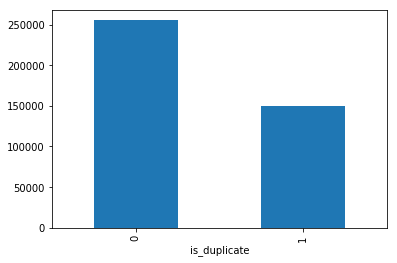

In [77]:
# 观察训练集的统计特征
# 训练集大小
print "数据集有 %d 对" % len(train_data)
# 相同问题对占总体训练集的比例
print "相同问题对占总体训练集的比例为 %f %%" % round(train_data['is_duplicate'].mean()*100.0, 3) 
# 总问题数
qids = pd.Series(train_data['qid1'].tolist() + train_data['qid2'].tolist())
print "总问题数 %d" % len(np.unique(qids))
# 有多少问题出现多次
print "有 %d 问题出现多次" % np.sum(qids.value_counts()>1)
# 分布情况
train_data.groupby("is_duplicate")['id'].count().plot.bar()

可以看出测试集相同的问题对大约占1/3

#### 测试集数据分析：

In [78]:
test_data = pd.read_csv("quora-question-pairs/test.csv")
print "测试集有 %d 对" %len(test_data)
# 显示前5条记录
display(test_data.head(n=5))
#test_data = test_data.head(2000)
test_len = len(test_data)

测试集有 2345796 对


,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [79]:
display(test_data.iloc[-6:-1])

,test_id,question1,question2
2345790,2345790,What should is the average cost for a call in ...,What are the types of models used in Cost Cent...
2345791,2345791,How do Peaks (TV series): Why did Leland kill ...,What is the most study scene in twin peaks?
2345792,2345792,"What does be ""in transit"" mean on FedEx tracking?",How question FedEx packages delivered?
2345793,2345793,What are some famous Romanian drinks (alcoholi...,Can a non-alcoholic restaurant be a huge success?
2345794,2345794,What were the best and worst things about publ...,What are the best and worst things examination...


### 探索性可视化

#### 使用词云图包探索

(-0.5, 1279.5, 979.5, -0.5)

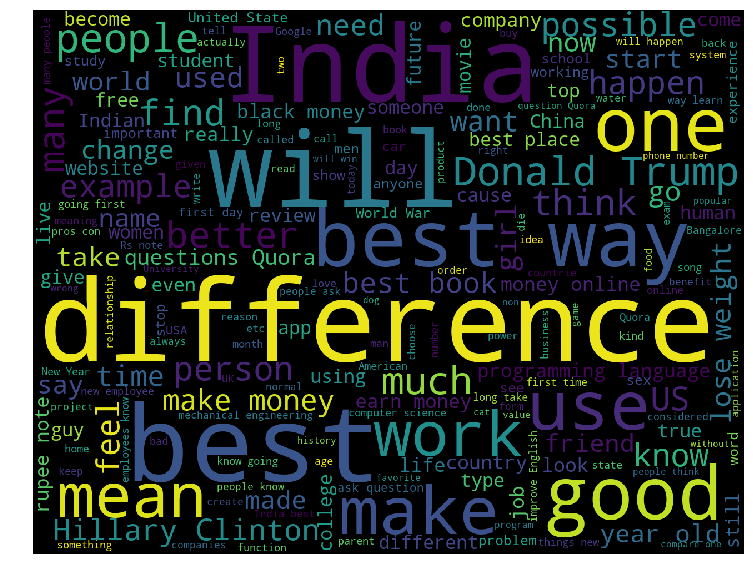

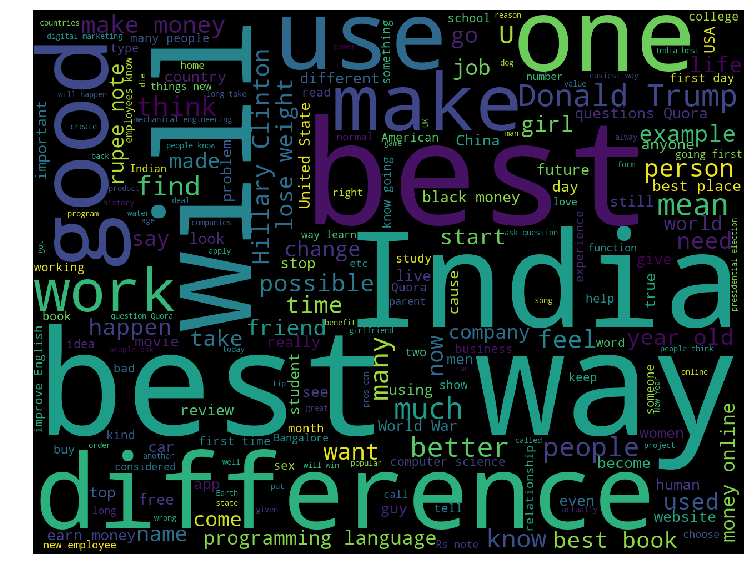

In [80]:
# 探索测试集的可视化
cloud1 = WordCloud(width=1280, height=980).generate(" ".join(train_data['question1'].astype(str)))
cloud2 = WordCloud(width=1280, height=980).generate(" ".join(train_data['question2'].astype(str)))
plt.figure(figsize=(15, 10))
plt.imshow(cloud1)
plt.axis('off')
plt.figure(figsize=(15, 10))
plt.imshow(cloud2)
plt.axis('off')

可以看出India, best way, good, will, people, work, better展现次数很多

### 算法和技术

先进行特征工程，提取一些相关的特征向量，之后尝试不同的模型进行训练，使用grid search来确认超参数，最后提交所有的结果，找到最佳的模型；准备尝试地模型有随机森林，逻辑回归，决策树，支持向量机，XGBoost等，具体细节见执行过程。

### 基准模型

准备把Random Forest作为基准模型，具体过程和基准的结果见执行过程。

## 3 方法

### 数据预处理

In [81]:
train_data.dropna()
test_data.dropna()
train_data.ix[train_data['question1'].isnull(),['question1']] = 'empty'
train_data.ix[train_data['question2'].isnull(),['question2']] = 'empty'
test_data.ix[test_data['question1'].isnull(),['question1']] = 'empty'
test_data.ix[test_data['question2'].isnull(),['question2']] = 'empty'

C:\Users\Administrator\Anaconda3\envs\python2.7\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Administrator\Anaconda3\envs\python2.7\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.
C:\Users\Administrator\Anaconda3\envs\python2.7\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pan

### 特诊向量提取

#### 基本向量

In [82]:
# 特征向量初始化
train_data_feature = pd.DataFrame(dtype='float64')
test_data_feature = pd.DataFrame(dtype='float64')
train_data_feature['len_q1'] = train_data.question1.apply(lambda x: len(str(x)))
train_data_feature['len_q2'] = train_data.question2.apply(lambda x: len(str(x)))
train_data_feature['diff_len'] = abs(train_data_feature.len_q1 - train_data_feature.len_q2)
train_data_feature['len_char_q1'] = train_data['question1'].str.len()
train_data_feature['len_char_q2'] = train_data['question2'].str.len()
train_data_feature['len_word_q1'] = train_data['question1'].apply(lambda x: len(str(x).split(" ")))
train_data_feature['len_word_q2'] = train_data['question2'].apply(lambda y: len(str(y).split(" ")))
train_data_feature['common_words'] = train_data.apply(lambda x: len(set(str(x['question1']).lower().split()).intersection(set(str(x['question2']).lower().split()))), axis=1)

test_data_feature['len_q1'] = test_data.question1.apply(lambda x: len(str(x)))
test_data_feature['len_q2'] = test_data.question2.apply(lambda x: len(str(x)))
test_data_feature['diff_len'] = abs(test_data_feature.len_q1 - test_data_feature.len_q2)
test_data_feature['len_char_q1'] = test_data['question1'].str.len()
test_data_feature['len_char_q2'] = test_data['question2'].str.len()
test_data_feature['len_word_q1'] = test_data['question1'].apply(lambda x: len(str(x).split(" ")))
test_data_feature['len_word_q2'] = test_data['question2'].apply(lambda y: len(str(y).split(" ")))
test_data_feature['common_words'] = train_data.apply(lambda x: len(set(str(x['question1']).lower().split()).intersection(set(str(x['question2']).lower().split()))), axis=1)

display(train_data_feature.head(5))
display(test_data_feature.head(5))

,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,common_words
0,66,57,9,66,57,14,12,10
1,51,88,37,51,88,8,13,4
2,73,59,14,73,59,14,10,4
3,50,65,15,50,65,11,9,0
4,76,39,37,76,39,13,7,2


,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,common_words
0,57,68,11,57,68,11,14,10.0
1,66,43,23,66,43,14,7,4.0
2,60,29,31,60,29,14,6,4.0
3,27,17,10,27,17,4,3,0.0
4,32,30,2,32,30,4,6,2.0


In [84]:
# 使用预训练的 tf-idf vectorizer 分别转化两个问题，然后使用 TruncatedSVD/NMF/LDA 得到维度各为 20-50 的特征集
pd.options.display.max_columns = None
pd.options.display.max_rows = None
import itertools
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer(min_df=1, stop_words='english', tokenizer=None)
svd_model = TruncatedSVD(n_components=20, algorithm='randomized', n_iter=5)
svd_transformer = Pipeline([('tfidf', vectorizer),
                            ('svd', svd_model)])

g = itertools.chain(train_data.question1, train_data.question2)
svd_transformer.fit(g)

q1, q2 = svd_transformer.transform(train_data.question1), svd_transformer.transform(train_data.question2)

#train_data_feature['cosine_distance'] = np.diag(cosine_similarity(q1, q2))
#train_data_feature['l2_distance'] = np.linalg.norm(q1 - q2, axis=1)
#train_data_feature['l1_distance'] = np.abs(q1 - q2).sum(axis=1)
df2 = pd.DataFrame(q1 - q2)
train_data_feature = pd.concat([train_data_feature,df2], axis=1)

In [85]:
vectorizer = TfidfVectorizer(min_df=1, stop_words='english', tokenizer=None)
svd_model = TruncatedSVD(n_components=20, algorithm='randomized', n_iter=5)
svd_transformer = Pipeline([('tfidf', vectorizer),
                            ('svd', svd_model)])

g = itertools.chain(test_data.question1, test_data.question2)
svd_transformer.fit(g)

q1, q2 = svd_transformer.transform(test_data.question1), svd_transformer.transform(test_data.question2)

#test_data_feature['cosine_distance'] = np.diag(cosine_similarity(q1, q2))
#test_data_feature['l2_distance'] = np.linalg.norm(q1 - q2, axis=1)
#test_data_feature['l1_distance'] = np.abs(q1 - q2).sum(axis=1)
df2 = pd.DataFrame(q1 - q2)
test_data_feature = pd.concat([test_data_feature,df2], axis=1)

In [87]:
display(test_data_feature.head(5))

,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,common_words,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,57,68,11,57,68,11,14,10.0,0.018852,0.124235,-0.089669,-0.044763,-0.011015,-0.048465,-0.033841,0.008475,0.016861,0.002317,-0.018616,-0.015590,-0.001273,-0.026207,-0.003800,0.025483,-0.035048,-0.007612,-0.080925,0.043060
1,66,43,23,66,43,14,7,4.0,-0.035308,-0.167136,0.102163,0.053673,0.011990,0.054283,0.039583,-0.003848,-0.016455,-0.006961,0.023752,0.018178,0.000865,0.017915,0.000201,-0.007312,0.010982,0.007179,0.010931,-0.008201
2,60,29,31,60,29,14,6,4.0,0.314484,-0.144246,-0.064222,-0.006025,-0.019572,-0.075832,0.001181,-0.000285,-0.014482,0.001139,-0.024535,0.023323,0.185722,-0.003177,-0.005475,0.128173,0.027260,-0.181321,-0.021851,0.015131
3,27,17,10,27,17,4,3,0.0,0.003191,0.002543,-0.000155,0.000103,-0.000624,0.001779,0.000644,-0.000588,-0.001891,-0.001102,-0.000124,-0.001292,0.001290,-0.000839,0.000938,-0.002339,0.000143,0.001713,0.001024,0.001765
4,32,30,2,32,30,4,6,2.0,-0.014465,-0.006774,-0.005436,-0.001915,-0.004203,-0.008864,-0.004787,0.001453,0.006087,-0.015422,0.003252,-0.007882,0.010246,-0.015617,0.036935,0.049007,-0.019243,0.031001,-0.008390,0.061503


In [88]:
display(train_data_feature.head(5))

,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,common_words,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,66,57,9,66,57,14,12,10,0.024536,0.014811,0.012101,0.016972,0.048374,-0.077032,-0.064282,-0.038481,0.075038,0.058781,0.032100,-0.041913,-0.012966,-0.053762,-0.052616,0.002984,0.013443,0.014365,-0.020309,0.002125
1,51,88,37,51,88,8,13,4,-0.006639,-0.013705,-0.006099,-0.008959,-0.020017,0.025196,0.011875,0.011911,-0.019419,0.026743,0.007979,-0.020538,-0.012474,-0.021411,-0.016517,0.000813,0.005437,-0.000170,-0.008932,0.011171
2,73,59,14,73,59,14,10,4,0.005170,0.011569,0.000407,-0.002226,-0.002867,-0.000416,-0.007065,-0.002809,-0.001822,-0.004986,0.008280,0.002076,-0.005627,0.007166,0.003833,-0.001276,-0.004762,0.018558,-0.001065,0.021550
3,50,65,15,50,65,11,9,0,-0.001044,0.000884,-0.000058,-0.001746,-0.000248,-0.003248,-0.006302,-0.001157,-0.003859,-0.001630,-0.003226,0.005614,0.000436,-0.002009,-0.000114,0.002440,0.002345,0.001594,-0.000822,0.000207
4,76,39,37,76,39,13,7,2,-0.001632,-0.002713,-0.000184,-0.003197,-0.000024,0.000247,0.000418,0.000564,0.000245,0.000470,-0.002347,0.000517,0.000079,0.001082,0.000445,0.000132,0.001403,-0.000636,-0.001979,0.000345


In [89]:
# fuzzy包相关特征 参考 https://github.com/abhishekkrthakur/is_that_a_duplicate_quora_question/blob/master/feature_engineering.py

import cPickle
import pandas as pd
import numpy as np
import gensim
from fuzzywuzzy import fuzz
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
from scipy.stats import skew, kurtosis
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis
from nltk import word_tokenize
stop_words = ['the','a','an','and','but','if','or','because','as','what','which','this','that','these','those','then',
              'just','so','than','such','both','through','about','for','is','of','while','during','to','What','Which',
              'Is','If','While','This']
# stop_words = stopwords.words('english')


In [90]:
# 计算指标函数

def wmd(s1, s2):
    s1 = str(s1).lower().split()
    s2 = str(s2).lower().split()
    # stop_words = stopwords.words('english')
    s1 = [w for w in s1 if w not in stop_words]
    s2 = [w for w in s2 if w not in stop_words]
    return model.wmdistance(s1, s2)


def norm_wmd(s1, s2):
    s1 = str(s1).lower().split()
    s2 = str(s2).lower().split()
    # stop_words = stopwords.words('english')
    s1 = [w for w in s1 if w not in stop_words]
    s2 = [w for w in s2 if w not in stop_words]
    return norm_model.wmdistance(s1, s2)


def sent2vec(s):
    words = str(s).lower().decode('utf-8')
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(model[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    return v / np.sqrt((v ** 2).sum())

In [91]:
# 使用fuzzywuzzy计算句子相似度

train_data_feature['fuzz_qratio'] = train_data.apply(lambda x: fuzz.QRatio(str(x['question1']), str(x['question2'])), axis=1)
train_data_feature['fuzz_WRatio'] = train_data.apply(lambda x: fuzz.WRatio(str(x['question1']), str(x['question2'])), axis=1)
train_data_feature['fuzz_partial_ratio'] = train_data.apply(lambda x: fuzz.partial_ratio(str(x['question1']), str(x['question2'])), axis=1)
train_data_feature['fuzz_partial_token_set_ratio'] = train_data.apply(lambda x: fuzz.partial_token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
train_data_feature['fuzz_partial_token_sort_ratio'] = train_data.apply(lambda x: fuzz.partial_token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)
train_data_feature['fuzz_token_set_ratio'] = train_data.apply(lambda x: fuzz.token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
train_data_feature['fuzz_token_sort_ratio'] = train_data.apply(lambda x: fuzz.token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)

test_data_feature['fuzz_qratio'] = test_data.apply(lambda x: fuzz.QRatio(str(x['question1']), str(x['question2'])), axis=1)
test_data_feature['fuzz_WRatio'] = test_data.apply(lambda x: fuzz.WRatio(str(x['question1']), str(x['question2'])), axis=1)
test_data_feature['fuzz_partial_ratio'] = test_data.apply(lambda x: fuzz.partial_ratio(str(x['question1']), str(x['question2'])), axis=1)
test_data_feature['fuzz_partial_token_set_ratio'] = test_data.apply(lambda x: fuzz.partial_token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
test_data_feature['fuzz_partial_token_sort_ratio'] = test_data.apply(lambda x: fuzz.partial_token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)
test_data_feature['fuzz_token_set_ratio'] = test_data.apply(lambda x: fuzz.token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
test_data_feature['fuzz_token_sort_ratio'] = test_data.apply(lambda x: fuzz.token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)

display(train_data_feature.head(5))
display(test_data_feature.head(5))

,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,common_words,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,fuzz_qratio,fuzz_WRatio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio
0,66,57,9,66,57,14,12,10,0.024536,0.014811,0.012101,0.016972,0.048374,-0.077032,-0.064282,-0.038481,0.075038,0.058781,0.032100,-0.041913,-0.012966,-0.053762,-0.052616,0.002984,0.013443,0.014365,-0.020309,0.002125,93,95,98,100,89,100,93
1,51,88,37,51,88,8,13,4,-0.006639,-0.013705,-0.006099,-0.008959,-0.020017,0.025196,0.011875,0.011911,-0.019419,0.026743,0.007979,-0.020538,-0.012474,-0.021411,-0.016517,0.000813,0.005437,-0.000170,-0.008932,0.011171,66,86,73,100,75,86,63
2,73,59,14,73,59,14,10,4,0.005170,0.011569,0.000407,-0.002226,-0.002867,-0.000416,-0.007065,-0.002809,-0.001822,-0.004986,0.008280,0.002076,-0.005627,0.007166,0.003833,-0.001276,-0.004762,0.018558,-0.001065,0.021550,54,63,53,100,71,66,66
3,50,65,15,50,65,11,9,0,-0.001044,0.000884,-0.000058,-0.001746,-0.000248,-0.003248,-0.006302,-0.001157,-0.003859,-0.001630,-0.003226,0.005614,0.000436,-0.002009,-0.000114,0.002440,0.002345,0.001594,-0.000822,0.000207,35,35,30,37,38,36,36
4,76,39,37,76,39,13,7,2,-0.001632,-0.002713,-0.000184,-0.003197,-0.000024,0.000247,0.000418,0.000564,0.000245,0.000470,-0.002347,0.000517,0.000079,0.001082,0.000445,0.000132,0.001403,-0.000636,-0.001979,0.000345,46,86,54,100,63,67,47


,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,common_words,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,fuzz_qratio,fuzz_WRatio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio
0,57,68,11,57,68,11,14,10.0,0.018852,0.124235,-0.089669,-0.044763,-0.011015,-0.048465,-0.033841,0.008475,0.016861,0.002317,-0.018616,-0.015590,-0.001273,-0.026207,-0.003800,0.025483,-0.035048,-0.007612,-0.080925,0.043060,46,55,46,100,59,58,55
1,66,43,23,66,43,14,7,4.0,-0.035308,-0.167136,0.102163,0.053673,0.011990,0.054283,0.039583,-0.003848,-0.016455,-0.006961,0.023752,0.018178,0.000865,0.017915,0.000201,-0.007312,0.010982,0.007179,0.010931,-0.008201,49,86,56,100,64,82,58
2,60,29,31,60,29,14,6,4.0,0.314484,-0.144246,-0.064222,-0.006025,-0.019572,-0.075832,0.001181,-0.000285,-0.014482,0.001139,-0.024535,0.023323,0.185722,-0.003177,-0.005475,0.128173,0.027260,-0.181321,-0.021851,0.015131,60,86,76,100,68,92,55
3,27,17,10,27,17,4,3,0.0,0.003191,0.002543,-0.000155,0.000103,-0.000624,0.001779,0.000644,-0.000588,-0.001891,-0.001102,-0.000124,-0.001292,0.001290,-0.000839,0.000938,-0.002339,0.000143,0.001713,0.001024,0.001765,52,54,53,63,63,52,52
4,32,30,2,32,30,4,6,2.0,-0.014465,-0.006774,-0.005436,-0.001915,-0.004203,-0.008864,-0.004787,0.001453,0.006087,-0.015422,0.003252,-0.007882,0.010246,-0.015617,0.036935,0.049007,-0.019243,0.031001,-0.008390,0.061503,70,70,63,100,66,74,66


In [92]:
# doc2vec特征，并计算有效的距离
# 训练集
# 出现类型和数值问题，效果不好，暂时弃用
import nltk
nltk.download('punkt')

model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)
train_data_feature['wmd'] = train_data.apply(lambda x: wmd(x['question1'], x['question2']), axis=1)


norm_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)
norm_model.init_sims(replace=True)
train_data_feature['norm_wmd'] = train_data.apply(lambda x: norm_wmd(x['question1'], x['question2']), axis=1)
error_count = 0

question1_vectors = np.zeros((train_data.shape[0], 300))
for i, q in tqdm(enumerate(train_data.question1.values)):
    question1_vectors[i, :] = sent2vec(q)

question2_vectors  = np.zeros((train_data.shape[0], 300))
for i, q in tqdm(enumerate(train_data.question2.values)):
    question2_vectors[i, :] = sent2vec(q)

train_data_feature['cosine_distance'] = [cosine(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors),np.nan_to_num(question2_vectors))]
train_data_feature['cityblock_distance'] = [cityblock(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors),np.nan_to_num(question2_vectors))]
train_data_feature['jaccard_distance'] = [jaccard(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors),np.nan_to_num(question2_vectors))]
train_data_feature['canberra_distance'] = [canberra(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors),np.nan_to_num(question2_vectors))]
train_data_feature['euclidean_distance'] = [euclidean(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors),np.nan_to_num(question2_vectors))]
train_data_feature['minkowski_distance'] = [minkowski(x, y, 3) for (x, y) in zip(np.nan_to_num(question1_vectors),np.nan_to_num(question2_vectors))]
train_data_feature['braycurtis_distance'] = [braycurtis(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors),np.nan_to_num(question2_vectors))]
train_data_feature['skew_q1vec'] = [skew(x) for x in np.nan_to_num(question1_vectors)]
train_data_feature['skew_q2vec'] = [skew(x) for x in np.nan_to_num(question2_vectors)]
train_data_feature['kur_q1vec'] = [kurtosis(x) for x in np.nan_to_num(question1_vectors)]
train_data_feature['kur_q2vec'] = [kurtosis(x) for x in np.nan_to_num(question2_vectors)]

display(train_data_feature.head(5))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\Administrator\Anaconda3\envs\python2.7\lib\site-packages\gensim\models\keyedvectors.py:412: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  return word in self.vocab
0it [00:00, ?it/s]C:\Users\Administrator\Anaconda3\envs\python2.7\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars
404290it [01:24, 4790.34it/s]
404290it [01:26, 4694.17it/s]


,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,common_words,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,fuzz_qratio,fuzz_WRatio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,wmd,norm_wmd,cosine_distance,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance,skew_q1vec,skew_q2vec,kur_q1vec,kur_q2vec
0,66,57,9,66,57,14,12,10,0.024536,0.014811,0.012101,0.016972,0.048374,-0.077032,-0.064282,-0.038481,0.075038,0.058781,0.032100,-0.041913,-0.012966,-0.053762,-0.052616,0.002984,0.013443,0.014365,-0.020309,0.002125,93,95,98,100,89,100,93,0.563226,0.244216,0.063406,4.869509,1.0,89.759695,0.356106,0.161325,0.179626,0.023941,-0.102680,0.095031,0.296524
1,51,88,37,51,88,8,13,4,-0.006639,-0.013705,-0.006099,-0.008959,-0.020017,0.025196,0.011875,0.011911,-0.019419,0.026743,0.007979,-0.020538,-0.012474,-0.021411,-0.016517,0.000813,0.005437,-0.000170,-0.008932,0.011171,66,86,73,100,75,86,63,3.772346,1.368796,0.512164,14.195119,1.0,177.588090,1.012091,0.455910,0.592655,0.008735,0.094704,0.284010,-0.034444
2,73,59,14,73,59,14,10,4,0.005170,0.011569,0.000407,-0.002226,-0.002867,-0.000416,-0.007065,-0.002809,-0.001822,-0.004986,0.008280,0.002076,-0.005627,0.007166,0.003833,-0.001276,-0.004762,0.018558,-0.001065,0.021550,54,63,53,100,71,66,66,1.645910,0.660150,0.213442,9.201546,1.0,134.665397,0.653363,0.291829,0.343318,0.029337,0.200552,-0.514036,-0.326208
3,50,65,15,50,65,11,9,0,-0.001044,0.000884,-0.000058,-0.001746,-0.000248,-0.003248,-0.006302,-0.001157,-0.003859,-0.001630,-0.003226,0.005614,0.000436,-0.002009,-0.000114,0.002440,0.002345,0.001594,-0.000822,0.000207,35,35,30,37,38,36,36,3.106745,1.263368,0.563036,14.894639,1.0,186.419017,1.061166,0.472624,0.639723,0.088374,0.065790,-0.365806,-0.321275
4,76,39,37,76,39,13,7,2,-0.001632,-0.002713,-0.000184,-0.003197,-0.000024,0.000247,0.000418,0.000564,0.000245,0.000470,-0.002347,0.000517,0.000079,0.001082,0.000445,0.000132,0.001403,-0.000636,-0.001979,0.000345,46,86,54,100,63,67,47,3.088408,1.062413,0.358203,11.895132,1.0,160.012510,0.846408,0.376750,0.472422,-0.132197,0.113997,0.193161,-0.457900


In [93]:
# 测试集
# 出现类型和数值问题，效果不好，暂时弃用
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)
test_data_feature['wmd'] = test_data.apply(lambda x: wmd(x['question1'], x['question2']), axis=1)


norm_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)
norm_model.init_sims(replace=True)
test_data_feature['norm_wmd'] = test_data.apply(lambda x: norm_wmd(x['question1'], x['question2']), axis=1)
error_count = 0

question1_vectors = np.zeros((test_data.shape[0], 300))
for i, q in tqdm(enumerate(test_data.question1.values)):
    question1_vectors[i, :] = sent2vec(q)

question2_vectors  = np.zeros((test_data.shape[0], 300))
for i, q in tqdm(enumerate(test_data.question2.values)):
    question2_vectors[i, :] = sent2vec(q)

test_data_feature['cosine_distance'] = [cosine(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors),np.nan_to_num(question2_vectors))]
test_data_feature['cityblock_distance'] = [cityblock(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors),np.nan_to_num(question2_vectors))]
test_data_feature['jaccard_distance'] = [jaccard(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors),np.nan_to_num(question2_vectors))]
test_data_feature['canberra_distance'] = [canberra(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors),np.nan_to_num(question2_vectors))]
test_data_feature['euclidean_distance'] = [euclidean(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors),np.nan_to_num(question2_vectors))]
test_data_feature['minkowski_distance'] = [minkowski(x, y, 3) for (x, y) in zip(np.nan_to_num(question1_vectors),np.nan_to_num(question2_vectors))]
test_data_feature['braycurtis_distance'] = [braycurtis(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors),np.nan_to_num(question2_vectors))]
test_data_feature['skew_q1vec'] = [skew(x) for x in np.nan_to_num(question1_vectors)]
test_data_feature['skew_q2vec'] = [skew(x) for x in np.nan_to_num(question2_vectors)]
test_data_feature['kur_q1vec'] = [kurtosis(x) for x in np.nan_to_num(question1_vectors)]
test_data_feature['kur_q2vec'] = [kurtosis(x) for x in np.nan_to_num(question2_vectors)]

display(test_data_feature.head(5))

0it [00:00, ?it/s]C:\Users\Administrator\Anaconda3\envs\python2.7\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars
2345796it [08:16, 4720.25it/s]
2345796it [08:18, 4709.68it/s]


,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,common_words,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,fuzz_qratio,fuzz_WRatio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,wmd,norm_wmd,cosine_distance,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance,skew_q1vec,skew_q2vec,kur_q1vec,kur_q2vec
0,57,68,11,57,68,11,14,10.0,0.018852,0.124235,-0.089669,-0.044763,-0.011015,-0.048465,-0.033841,0.008475,0.016861,0.002317,-0.018616,-0.015590,-0.001273,-0.026207,-0.003800,0.025483,-0.035048,-0.007612,-0.080925,0.043060,46,55,46,100,59,58,55,2.696191,0.976150,0.312874,10.777264,1.0,153.428540,0.791043,0.361167,0.430802,0.041778,0.096209,-0.035010,0.335741
1,66,43,23,66,43,14,7,4.0,-0.035308,-0.167136,0.102163,0.053673,0.011990,0.054283,0.039583,-0.003848,-0.016455,-0.006961,0.023752,0.018178,0.000865,0.017915,0.000201,-0.007312,0.010982,0.007179,0.010931,-0.008201,49,86,56,100,64,82,58,1.797246,0.748903,0.148041,7.621517,1.0,120.561720,0.544134,0.242877,0.284691,0.002891,0.020431,0.073109,-0.050078
2,60,29,31,60,29,14,6,4.0,0.314484,-0.144246,-0.064222,-0.006025,-0.019572,-0.075832,0.001181,-0.000285,-0.014482,0.001139,-0.024535,0.023323,0.185722,-0.003177,-0.005475,0.128173,0.027260,-0.181321,-0.021851,0.015131,60,86,76,100,68,92,55,2.008187,0.837192,0.148473,7.562350,1.0,120.713599,0.544928,0.244935,0.278133,0.056927,0.198574,-0.471949,-0.265051
3,27,17,10,27,17,4,3,0.0,0.003191,0.002543,-0.000155,0.000103,-0.000624,0.001779,0.000644,-0.000588,-0.001891,-0.001102,-0.000124,-0.001292,0.001290,-0.000839,0.000938,-0.002339,0.000143,0.001713,0.001024,0.001765,52,54,53,63,63,52,52,3.016385,1.060025,0.326700,10.903597,1.0,154.239197,0.808332,0.370082,0.436055,-0.088740,0.069599,-0.346909,0.774025
4,32,30,2,32,30,4,6,2.0,-0.014465,-0.006774,-0.005436,-0.001915,-0.004203,-0.008864,-0.004787,0.001453,0.006087,-0.015422,0.003252,-0.007882,0.010246,-0.015617,0.036935,0.049007,-0.019243,0.031001,-0.008390,0.061503,70,70,63,100,66,74,66,1.653671,0.745724,0.177735,8.131231,1.0,130.429611,0.596213,0.272993,0.309902,-0.024084,-0.039261,-0.158121,0.259081


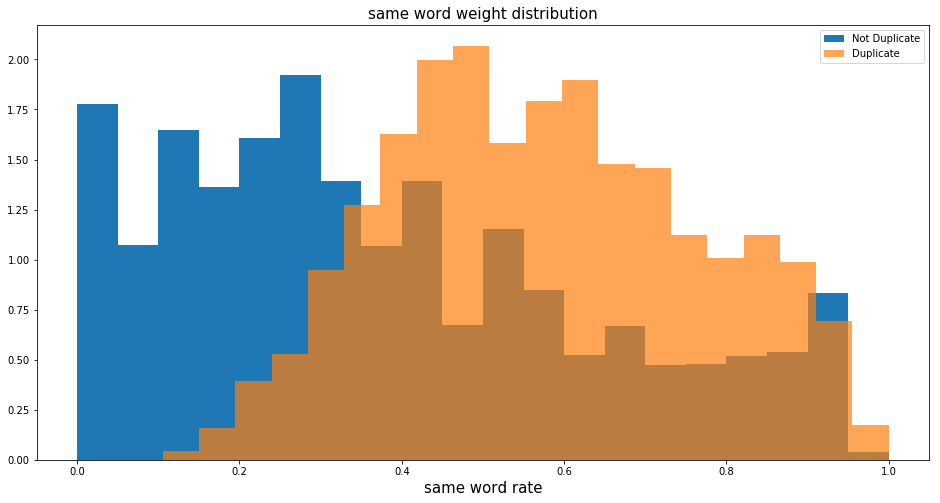

In [94]:
# 计算相同词的比重
def get_same_word_weight(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        q1words[word] = 1
    for word in str(row['question2']).lower().split():
        q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = 1.0 *(len(shared_words_in_q1) + len(shared_words_in_q2)) / float((len(q1words) + len(q2words)))
    return R

plt.figure(figsize=(16, 8))
same_word_weight_train = train_data.apply(get_same_word_weight, axis=1, raw=True)
same_word_weight_test = test_data.apply(get_same_word_weight, axis=1, raw=False)
plt.hist(same_word_weight_train[train_data['is_duplicate'] == 0], bins=20, normed=True, label='Not Duplicate')
plt.hist(same_word_weight_train[train_data['is_duplicate'] == 1], bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('same word weight distribution', fontsize=15)
plt.xlabel('same word rate', fontsize=15)

train_data_feature['same_word_weight'] = same_word_weight_train
test_data_feature['same_word_weight'] = same_word_weight_test


#### 编辑距离 Levenshtein

Text(0,0.5,'Distribution')

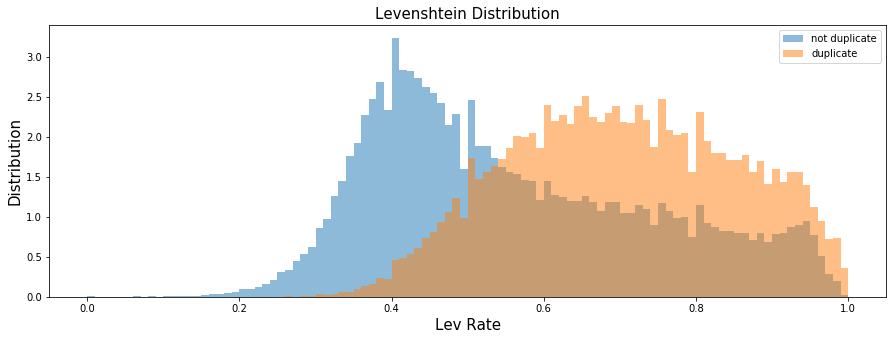

In [95]:
import Levenshtein as lev

lev_train = []
for r in zip(train_data['question1'].astype(str), train_data['question2'].astype(str)):
    lev_train.append(lev.ratio(r[0], r[1]))
train_data_feature['lev_ratio'] = lev_train

lev_test = []
for r in zip(test_data['question1'].astype(str), test_data['question2'].astype(str)):
    lev_test.append(lev.ratio(r[0], r[1]))
test_data_feature['lev_ratio'] = lev_test

plt.figure(figsize=(15, 5))
plt.hist(train_data_feature[train_data['is_duplicate']== 0]['lev_ratio'], bins=100, range=[0, 1], normed=True, alpha=0.5, label='not duplicate')
plt.hist(train_data_feature[train_data['is_duplicate']== 1]['lev_ratio'], bins=100, range=[0, 1], normed=True, alpha=0.5, label='duplicate')
plt.title('Levenshtein Distribution', fontsize=15)
plt.legend()
plt.xlabel('Lev Rate', fontsize=15)
plt.ylabel('Distribution', fontsize=15)

#### 用tfidf计算相似度

In [96]:
# 组合所有问题
train_questions = pd.Series(train_data['question1'].tolist() + train_data['question2'].tolist()).astype(str)
test_questions = pd.Series(test_data['question1'].tolist() + test_data['question2'].tolist()).astype(str)

# 生成对应的vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(min_df = 2)
tfidf_matrix = tfidf_vectorizer.fit_transform(train_questions)

# 每个问题生成相应的向量
trainQuestion1_tf_vector = tfidf_vectorizer.transform(train_data.ix[:,'question1'])
trainQuestion2_tf_vector = tfidf_vectorizer.transform(train_data.ix[:,'question2'])

print("Train Question 1 Shape: ", trainQuestion1_tf_vector.shape)
print("Train Question 2 Shape: ", trainQuestion2_tf_vector.shape)



C:\Users\Administrator\Anaconda3\envs\python2.7\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Administrator\Anaconda3\envs\python2.7\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if sys.path[0] == '':


('Train Question 1 Shape: ', (404290, 51799))
('Train Question 2 Shape: ', (404290, 51799))


In [97]:
from sklearn.metrics.pairwise import cosine_similarity

cos_similarity_train = []

#for x in range(0,404290):
#    cos_similarity_train.append((cosine_similarity(trainQuestion1_tf_vector[x],trainQuestion2_tf_vector[x]))[0][0])
#    x = x + 1
for x in range(0,train_len):
    cos_similarity_train.append((cosine_similarity(trainQuestion1_tf_vector[x],trainQuestion2_tf_vector[x]))[0][0])
    x = x + 1

Text(0,0.5,'Distribution')

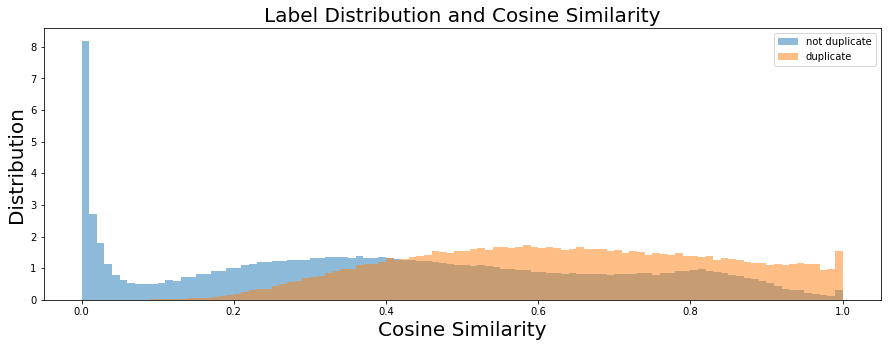

In [98]:
train_data_feature['cos_sim'] = cos_similarity_train

# 可视化
plt.figure(figsize=(15, 5))
plt.hist(train_data_feature[train_data['is_duplicate']== 0]['cos_sim'], bins=100, range=[0, 1], normed=True, alpha=0.5, label='not duplicate')
plt.hist(train_data_feature[train_data['is_duplicate']== 1]['cos_sim'], bins=100, range=[0, 1], normed=True, alpha=0.5, label='duplicate')
plt.title('Label Distribution and Cosine Similarity', fontsize=20)
plt.legend()
plt.xlabel('Cosine Similarity', fontsize=20)
plt.ylabel('Distribution', fontsize=20)

In [99]:
# 每个问题生成相应的向量
testQuestion1_tf_vector = tfidf_vectorizer.transform(test_data.ix[:,'question1'])
testQuestion2_tf_vector = tfidf_vectorizer.transform(test_data.ix[:,'question2'])

print("Test Question 1 Shape: ", testQuestion1_tf_vector.shape)
print("Test Question 2 Shape: ", testQuestion2_tf_vector.shape)


C:\Users\Administrator\Anaconda3\envs\python2.7\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
C:\Users\Administrator\Anaconda3\envs\python2.7\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


('Test Question 1 Shape: ', (2345796, 51799))
('Test Question 2 Shape: ', (2345796, 51799))


In [100]:
cos_similarity_test = []
for x in range(0,test_len):
    cos_similarity_test.append((cosine_similarity(testQuestion1_tf_vector[x],testQuestion2_tf_vector[x]))[0][0])
    x = x + 1

In [101]:
test_data_feature['cos_sim'] = cos_similarity_test
display(test_data_feature.head(5))

,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,common_words,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,fuzz_qratio,fuzz_WRatio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,wmd,norm_wmd,cosine_distance,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance,skew_q1vec,skew_q2vec,kur_q1vec,kur_q2vec,same_word_weight,lev_ratio,cos_sim
0,57,68,11,57,68,11,14,10.0,0.018852,0.124235,-0.089669,-0.044763,-0.011015,-0.048465,-0.033841,0.008475,0.016861,0.002317,-0.018616,-0.015590,-0.001273,-0.026207,-0.003800,0.025483,-0.035048,-0.007612,-0.080925,0.043060,46,55,46,100,59,58,55,2.696191,0.976150,0.312874,10.777264,1.0,153.428540,0.791043,0.361167,0.430802,0.041778,0.096209,-0.035010,0.335741,0.166667,0.448000,0.281145
1,66,43,23,66,43,14,7,4.0,-0.035308,-0.167136,0.102163,0.053673,0.011990,0.054283,0.039583,-0.003848,-0.016455,-0.006961,0.023752,0.018178,0.000865,0.017915,0.000201,-0.007312,0.010982,0.007179,0.010931,-0.008201,49,86,56,100,64,82,58,1.797246,0.748903,0.148041,7.621517,1.0,120.561720,0.544134,0.242877,0.284691,0.002891,0.020431,0.073109,-0.050078,0.380952,0.477064,0.604399
2,60,29,31,60,29,14,6,4.0,0.314484,-0.144246,-0.064222,-0.006025,-0.019572,-0.075832,0.001181,-0.000285,-0.014482,0.001139,-0.024535,0.023323,0.185722,-0.003177,-0.005475,0.128173,0.027260,-0.181321,-0.021851,0.015131,60,86,76,100,68,92,55,2.008187,0.837192,0.148473,7.562350,1.0,120.713599,0.544928,0.244935,0.278133,0.056927,0.198574,-0.471949,-0.265051,0.444444,0.606742,0.683008
3,27,17,10,27,17,4,3,0.0,0.003191,0.002543,-0.000155,0.000103,-0.000624,0.001779,0.000644,-0.000588,-0.001891,-0.001102,-0.000124,-0.001292,0.001290,-0.000839,0.000938,-0.002339,0.000143,0.001713,0.001024,0.001765,52,54,53,63,63,52,52,3.016385,1.060025,0.326700,10.903597,1.0,154.239197,0.808332,0.370082,0.436055,-0.088740,0.069599,-0.346909,0.774025,0.000000,0.545455,0.000000
4,32,30,2,32,30,4,6,2.0,-0.014465,-0.006774,-0.005436,-0.001915,-0.004203,-0.008864,-0.004787,0.001453,0.006087,-0.015422,0.003252,-0.007882,0.010246,-0.015617,0.036935,0.049007,-0.019243,0.031001,-0.008390,0.061503,70,70,63,100,66,74,66,1.653671,0.745724,0.177735,8.131231,1.0,130.429611,0.596213,0.272993,0.309902,-0.024084,-0.039261,-0.158121,0.259081,0.600000,0.677419,0.847157


### 执行过程

In [102]:
train_data_feature_backup = train_data_feature.copy()
test_data_feature_backup = test_data_feature.copy()
display(train_data_feature_backup.head())

,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,common_words,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,fuzz_qratio,fuzz_WRatio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,wmd,norm_wmd,cosine_distance,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance,skew_q1vec,skew_q2vec,kur_q1vec,kur_q2vec,same_word_weight,lev_ratio,cos_sim
0,66,57,9,66,57,14,12,10,0.024536,0.014811,0.012101,0.016972,0.048374,-0.077032,-0.064282,-0.038481,0.075038,0.058781,0.032100,-0.041913,-0.012966,-0.053762,-0.052616,0.002984,0.013443,0.014365,-0.020309,0.002125,93,95,98,100,89,100,93,0.563226,0.244216,0.063406,4.869509,1.0,89.759695,0.356106,0.161325,0.179626,0.023941,-0.102680,0.095031,0.296524,0.869565,0.926829,0.978515
1,51,88,37,51,88,8,13,4,-0.006639,-0.013705,-0.006099,-0.008959,-0.020017,0.025196,0.011875,0.011911,-0.019419,0.026743,0.007979,-0.020538,-0.012474,-0.021411,-0.016517,0.000813,0.005437,-0.000170,-0.008932,0.011171,66,86,73,100,75,86,63,3.772346,1.368796,0.512164,14.195119,1.0,177.588090,1.012091,0.455910,0.592655,0.008735,0.094704,0.284010,-0.034444,0.400000,0.647482,0.749755
2,73,59,14,73,59,14,10,4,0.005170,0.011569,0.000407,-0.002226,-0.002867,-0.000416,-0.007065,-0.002809,-0.001822,-0.004986,0.008280,0.002076,-0.005627,0.007166,0.003833,-0.001276,-0.004762,0.018558,-0.001065,0.021550,54,63,53,100,71,66,66,1.645910,0.660150,0.213442,9.201546,1.0,134.665397,0.653363,0.291829,0.343318,0.029337,0.200552,-0.514036,-0.326208,0.333333,0.545455,0.254677
3,50,65,15,50,65,11,9,0,-0.001044,0.000884,-0.000058,-0.001746,-0.000248,-0.003248,-0.006302,-0.001157,-0.003859,-0.001630,-0.003226,0.005614,0.000436,-0.002009,-0.000114,0.002440,0.002345,0.001594,-0.000822,0.000207,35,35,30,37,38,36,36,3.106745,1.263368,0.563036,14.894639,1.0,186.419017,1.061166,0.472624,0.639723,0.088374,0.065790,-0.365806,-0.321275,0.000000,0.278261,0.000000
4,76,39,37,76,39,13,7,2,-0.001632,-0.002713,-0.000184,-0.003197,-0.000024,0.000247,0.000418,0.000564,0.000245,0.000470,-0.002347,0.000517,0.000079,0.001082,0.000445,0.000132,0.001403,-0.000636,-0.001979,0.000345,46,86,54,100,63,67,47,3.088408,1.062413,0.358203,11.895132,1.0,160.012510,0.846408,0.376750,0.472422,-0.132197,0.113997,0.193161,-0.457900,0.200000,0.452174,0.260064


#### 标准化每一个向量以及分割测试集

In [103]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None
train_data_feature=train_data_feature.replace([np.inf,-np.inf],1)
train_data_feature=train_data_feature.replace(np.nan,0)
test_data_feature=test_data_feature.replace([np.inf,-np.inf],1)
test_data_feature=test_data_feature.replace(np.nan,0)
#train_data_feature=train_data_feature[np.isinf(train_data_feature)]=1

In [105]:
display(test_data_feature.columns.values.tolist())

['len_q1',
 'len_q2',
 'diff_len',
 'len_char_q1',
 'len_char_q2',
 'len_word_q1',
 'len_word_q2',
 'common_words',
 0L,
 1L,
 2L,
 3L,
 4L,
 5L,
 6L,
 7L,
 8L,
 9L,
 10L,
 11L,
 12L,
 13L,
 14L,
 15L,
 16L,
 17L,
 18L,
 19L,
 'fuzz_qratio',
 'fuzz_WRatio',
 'fuzz_partial_ratio',
 'fuzz_partial_token_set_ratio',
 'fuzz_partial_token_sort_ratio',
 'fuzz_token_set_ratio',
 'fuzz_token_sort_ratio',
 'wmd',
 'norm_wmd',
 'cosine_distance',
 'cityblock_distance',
 'jaccard_distance',
 'canberra_distance',
 'euclidean_distance',
 'minkowski_distance',
 'braycurtis_distance',
 'skew_q1vec',
 'skew_q2vec',
 'kur_q1vec',
 'kur_q2vec',
 'same_word_weight',
 'lev_ratio',
 'cos_sim']

In [106]:
# 标准化每个向量
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
numerical = test_data_feature.columns.values.tolist()
train_data_scaled = train_data_feature.copy()
test_data_scaled = test_data_feature.copy()

train_data_scaled[numerical] = scaler.fit_transform(train_data_feature[numerical])
test_data_scaled[numerical] = scaler.fit_transform(test_data_feature[numerical])


In [107]:
display(train_data_scaled.head(5))

,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,common_words,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,fuzz_qratio,fuzz_WRatio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,wmd,norm_wmd,cosine_distance,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance,skew_q1vec,skew_q2vec,kur_q1vec,kur_q2vec,same_word_weight,lev_ratio,cos_sim
0,0.104502,0.047945,0.008333,0.104502,0.047945,0.104839,0.046610,0.243902,0.555844,0.500490,0.458769,0.504785,0.525753,0.443028,0.450429,0.525994,0.606074,0.588114,0.562175,0.495661,0.479908,0.392517,0.364283,0.521008,0.490155,0.578169,0.430020,0.476149,0.93,0.95,0.98,1.00,0.89,1.00,0.93,0.081119,0.164832,0.057695,0.236039,1.0,0.299199,0.240198,0.238521,0.159775,0.534975,0.425179,0.557509,0.630697,0.869565,0.928571,0.978515
1,0.080386,0.074486,0.034259,0.080386,0.074486,0.056452,0.050847,0.097561,0.535300,0.479987,0.443708,0.483519,0.489344,0.518635,0.517585,0.570845,0.499871,0.558248,0.541344,0.515927,0.480344,0.423479,0.394276,0.519560,0.484649,0.567854,0.439666,0.483193,0.66,0.86,0.73,1.00,0.75,0.86,0.63,0.543312,0.923858,0.466036,0.688078,1.0,0.591960,0.682668,0.674070,0.527159,0.523243,0.572942,0.591550,0.567376,0.400000,0.648699,0.749755
2,0.115756,0.049658,0.012963,0.115756,0.049658,0.104839,0.038136,0.097561,0.543082,0.498159,0.449092,0.489040,0.498474,0.499692,0.500883,0.557744,0.519656,0.528668,0.541604,0.537368,0.486412,0.450830,0.411186,0.518168,0.477636,0.581145,0.446336,0.491276,0.54,0.63,0.53,1.00,0.71,0.66,0.66,0.237052,0.445563,0.194218,0.446025,1.0,0.448885,0.440701,0.431473,0.305377,0.539138,0.652181,0.447798,0.511555,0.333333,0.546480,0.254677
3,0.078778,0.054795,0.013889,0.078778,0.054795,0.080645,0.033898,0.000000,0.538987,0.490477,0.448707,0.489434,0.499868,0.497598,0.501556,0.559214,0.517366,0.531797,0.531668,0.540722,0.491786,0.442049,0.407906,0.520645,0.482523,0.569106,0.446542,0.474655,0.35,0.35,0.30,0.37,0.38,0.36,0.36,0.447449,0.852700,0.512326,0.721986,1.0,0.621397,0.715770,0.698781,0.569025,0.584687,0.551297,0.474499,0.512499,0.000000,0.278784,0.000000
4,0.120579,0.032534,0.034259,0.120579,0.032534,0.096774,0.025424,0.048780,0.538599,0.487890,0.448603,0.488244,0.499987,0.500183,0.507481,0.560746,0.521980,0.533755,0.532427,0.535890,0.491469,0.445007,0.408371,0.519106,0.481875,0.567523,0.445561,0.474763,0.46,0.86,0.54,1.00,0.63,0.67,0.47,0.444808,0.717067,0.325941,0.576591,1.0,0.533375,0.570913,0.557030,0.420213,0.414509,0.587385,0.575186,0.486360,0.200000,0.453024,0.260064


In [108]:
display(test_data_scaled.head(5))

,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,common_words,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,fuzz_qratio,fuzz_WRatio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,wmd,norm_wmd,cosine_distance,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance,skew_q1vec,skew_q2vec,kur_q1vec,kur_q2vec,same_word_weight,lev_ratio,cos_sim
0,0.047822,0.057021,0.010166,0.047822,0.057021,0.042194,0.054852,0.243902,0.511871,0.567333,0.463323,0.452602,0.511332,0.464602,0.446597,0.563076,0.434678,0.496690,0.481000,0.501293,0.492166,0.483702,0.509903,0.544905,0.476170,0.466629,0.449464,0.501866,0.46,0.55,0.46,1.00,0.59,0.58,0.55,0.390181,0.638307,0.271426,0.508306,1.0,0.511428,0.520986,0.527666,0.365878,0.539200,0.581965,0.491630,0.593468,0.166667,0.448000,0.281145
1,0.055508,0.035745,0.021257,0.055508,0.035745,0.054852,0.025316,0.097561,0.477967,0.395163,0.570967,0.509132,0.524540,0.514292,0.499917,0.556734,0.415039,0.491170,0.507782,0.524719,0.493408,0.511141,0.511749,0.518409,0.509255,0.476817,0.506860,0.474274,0.49,0.86,0.56,1.00,0.64,0.82,0.58,0.260090,0.489710,0.128429,0.359467,1.0,0.401872,0.358370,0.354844,0.241786,0.511046,0.532384,0.509558,0.524827,0.380952,0.477064,0.604399
2,0.050384,0.023830,0.028651,0.050384,0.023830,0.054852,0.021097,0.097561,0.696933,0.408688,0.477602,0.474849,0.506418,0.451367,0.472030,0.558568,0.416202,0.495990,0.477258,0.528289,0.600774,0.498024,0.509131,0.627872,0.520956,0.346978,0.486376,0.486833,0.60,0.86,0.76,1.00,0.68,0.92,0.55,0.290616,0.547443,0.128804,0.356676,1.0,0.402379,0.358893,0.357851,0.236217,0.550168,0.648942,0.419181,0.486580,0.444444,0.606742,0.683008
3,0.022203,0.013617,0.009242,0.022203,0.013617,0.012658,0.008439,0.000000,0.502067,0.495425,0.513552,0.478368,0.517298,0.488901,0.471640,0.558412,0.423624,0.494656,0.492689,0.511212,0.493655,0.499478,0.512089,0.522427,0.501464,0.473052,0.500670,0.479638,0.52,0.54,0.53,0.63,0.63,0.52,0.52,0.436519,0.693153,0.283421,0.514265,1.0,0.514131,0.532373,0.540691,0.370339,0.444706,0.564554,0.439914,0.671444,0.000000,0.545455,0.000000
4,0.026473,0.024681,0.001848,0.026473,0.024681,0.012658,0.021097,0.048780,0.491015,0.489920,0.510589,0.477209,0.515243,0.483753,0.467696,0.559462,0.428327,0.486137,0.494823,0.506641,0.498856,0.490288,0.528697,0.563911,0.487530,0.493226,0.494787,0.511793,0.70,0.70,0.63,1.00,0.66,0.74,0.66,0.239312,0.487631,0.154190,0.383507,1.0,0.434765,0.392670,0.398844,0.263198,0.491517,0.493328,0.471217,0.579830,0.600000,0.677419,0.847157


In [109]:
# 把测试集分为测试集和验证集
label = train_data['is_duplicate']
x_train, x_valid, y_train, y_valid = train_test_split(train_data_scaled, label, test_size=0.2, random_state=1)


In [110]:
display(x_train.head(5))

,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,common_words,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,fuzz_qratio,fuzz_WRatio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,wmd,norm_wmd,cosine_distance,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance,skew_q1vec,skew_q2vec,kur_q1vec,kur_q2vec,same_word_weight,lev_ratio,cos_sim
92191,0.061093,0.030822,0.001852,0.061093,0.030822,0.048387,0.021186,0.121951,0.531654,0.490142,0.450910,0.489436,0.500624,0.494492,0.457416,0.563769,0.461698,0.530711,0.523975,0.461213,0.567331,0.445030,0.430095,0.522311,0.492665,0.574764,0.452254,0.464523,0.95,0.95,0.92,1.0,0.92,0.95,0.95,0.081053,0.143646,0.060720,0.235097,1.0,0.312735,0.246415,0.248028,0.159954,0.605548,0.636042,0.559790,0.574661,0.769231,0.949149,0.573620
306704,0.072347,0.033390,0.005556,0.072347,0.033390,0.064516,0.029661,0.121951,0.519284,0.374817,0.448188,0.332880,0.559826,0.494679,0.517069,0.550015,0.545943,0.524665,0.551114,0.514004,0.485809,0.465630,0.403174,0.523265,0.479680,0.567072,0.464069,0.482410,0.74,0.81,0.78,1.0,0.79,0.85,0.76,0.198361,0.340819,0.210293,0.468205,1.0,0.468052,0.458577,0.450507,0.321331,0.430397,0.628938,0.474323,0.487175,0.588235,0.745585,0.758448
139696,0.189711,0.064212,0.039815,0.189711,0.064212,0.161290,0.055085,0.146341,0.535627,0.467165,0.444197,0.463948,0.512443,0.503167,0.513937,0.559077,0.515380,0.549357,0.545457,0.535092,0.494178,0.445320,0.403957,0.521199,0.479973,0.568684,0.449207,0.477110,0.41,0.86,0.47,1.0,0.57,0.66,0.55,0.243972,0.462162,0.150378,0.383560,1.0,0.424006,0.387785,0.382707,0.267319,0.447477,0.571644,0.568298,0.561316,0.363636,0.421303,0.417206
19278,0.046624,0.023973,0.000926,0.046624,0.023973,0.040323,0.025424,0.097561,0.538853,0.488616,0.448701,0.489245,0.499574,0.500711,0.507441,0.560594,0.521074,0.532443,0.533526,0.536224,0.491909,0.443896,0.407421,0.519909,0.480733,0.567669,0.446297,0.473432,0.74,0.80,0.76,1.0,0.75,0.84,0.74,0.315241,0.600808,0.188606,0.430926,1.0,0.458929,0.434288,0.428805,0.302690,0.448111,0.596824,0.518753,0.565935,0.666667,0.713202,0.682462
23863,0.075563,0.038527,0.001852,0.075563,0.038527,0.064516,0.033898,0.195122,0.541229,0.492163,0.449281,0.493853,0.499834,0.499080,0.505372,0.559260,0.522257,0.529999,0.536326,0.535565,0.491173,0.443230,0.407795,0.519128,0.479482,0.567287,0.447445,0.474229,0.93,0.93,0.91,1.0,0.86,0.95,0.89,0.115879,0.192041,0.102682,0.319705,1.0,0.393832,0.320440,0.313822,0.219750,0.520779,0.499338,0.559041,0.538608,0.888889,0.937930,0.822924


In [111]:
display(y_train.head(5))

92191     1
306704    0
139696    1
19278     1
23863     0
Name: is_duplicate, dtype: int64

In [112]:
display(len(test_data_scaled))

2345796

#### 基本模型：随机森林

In [113]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss 

parameters_rf = {'n_estimators':[16, 32, 64, 128, 512], 'random_state':[0]}


rand_forest_clf = RandomForestClassifier()
cv_rf = GridSearchCV(rand_forest_clf, parameters_rf)

cv_rf = cv_rf.fit(x_train, y_train)
print("Best estimator: ", cv_rf.best_estimator_)

('Best estimator: ', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=512, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False))


In [114]:
rand_forest_y_pred = cv_rf.predict_proba(x_valid)
log_loss(y_valid, rand_forest_y_pred[:,1])

0.4210279800717873

In [115]:
rand_forest_test_pred = cv_rf.predict_proba(test_data_scaled)

In [116]:
sub = pd.DataFrame()
sub['test_id'] = test_data['test_id']
sub['is_duplicate'] = rand_forest_test_pred[:,1]
sub.to_csv('random_forest_sub.csv', index=False)

In [117]:
display(len(sub))

2345796

In [118]:
display(rand_forest_test_pred[:5])

array([[0.79882812, 0.20117188],
       [0.46679688, 0.53320312],
       [0.42578125, 0.57421875],
       [0.84179688, 0.15820312],
       [0.44726562, 0.55273438]])

#### 决策树算法

In [119]:
dt = DecisionTreeClassifier(max_depth = 100, random_state=10)
dt.fit(x_train, y_train)
dt_y_pred = dt.predict(x_valid)


In [120]:
display(dt_y_pred[:5])

array([1, 1, 0, 0, 0], dtype=int64)

In [121]:
log_loss(y_valid, dt_y_pred)

9.879748271566388

In [122]:
decision_tree_test_pred = dt.predict_proba(test_data_scaled)

In [123]:
sub = pd.DataFrame()
sub['test_id'] = test_data['test_id']
sub['is_duplicate'] = decision_tree_test_pred[:,1]
sub.to_csv('new_decision_tree_sub.csv', index=False)

In [124]:
display(len(sub))

2345796

In [125]:
test_data_scaled.to_csv('testdata.csv', index=False)

In [126]:
display(test_data.iloc[-6:-1])

,test_id,question1,question2
2345790,2345790,What should is the average cost for a call in ...,What are the types of models used in Cost Cent...
2345791,2345791,How do Peaks (TV series): Why did Leland kill ...,What is the most study scene in twin peaks?
2345792,2345792,"What does be ""in transit"" mean on FedEx tracking?",How question FedEx packages delivered?
2345793,2345793,What are some famous Romanian drinks (alcoholi...,Can a non-alcoholic restaurant be a huge success?
2345794,2345794,What were the best and worst things about publ...,What are the best and worst things examination...


In [127]:
display(sub.iloc[-6:-1])

,test_id,is_duplicate
2345790,2345790,0.0
2345791,2345791,0.0
2345792,2345792,0.0
2345793,2345793,0.0
2345794,2345794,1.0


In [128]:
display(pd.DataFrame(decision_tree_test_pred).iloc[1128100:1128130])

,0,1
1128100,0.0,1.0
1128101,0.0,1.0
1128102,1.0,0.0
1128103,1.0,0.0
1128104,1.0,0.0
1128105,1.0,0.0
1128106,1.0,0.0
1128107,1.0,0.0
1128108,0.0,1.0
1128109,0.0,1.0


#### 支持向量机

In [129]:
svm = SVC(random_state=0, max_iter=500, probability=True)
grid = {
    'C': [1e0, 1e3],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}
cv = GridSearchCV(svm, grid, scoring='neg_log_loss', verbose = True)
cv.fit(x_train, y_train)
print cv.best_params_
score_svm = cv.best_estimator_.score(x_valid, y_valid)
print "SVM model accuracy: %.3f" % score_svm

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 64.1min finished


{'kernel': 'sigmoid', 'C': 1.0}
SVM model accuracy: 0.680


In [130]:
svm = SVC(random_state=0, max_iter=1000, probability=True, kernel='linear', C=1.0)
svm.fit(x_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=1000, probability=True, random_state=0,
  shrinking=True, tol=0.001, verbose=False)

In [131]:
svm_y_pred = svm.predict_proba(x_valid)
log_loss(y_valid, svm_y_pred[:,1])

0.5940690946566914

In [132]:
svm_test_pred = svm.predict_proba(test_data_scaled)

In [133]:
sub = pd.DataFrame()
sub['test_id'] = test_data['test_id']
sub['is_duplicate'] = svm_test_pred[:,1]
sub.to_csv('svm_sub.csv', index=False)

#### 逻辑回归

In [134]:
from sklearn.linear_model import LogisticRegression

parameters_lr = {'solver':['sag'], 'C':[.01, 0.001, 0.0001], 'random_state':[0]}

logreg = LogisticRegression()
cv_lr = GridSearchCV(logreg, parameters_lr)
cv_lr = cv_lr.fit(x_train, y_train)
print("Best estimator: ", cv_lr.best_estimator_)

('Best estimator: ', LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='sag',
          tol=0.0001, verbose=0, warm_start=False))


In [135]:
logreg_y_pred = cv_lr.predict_proba(x_valid)

log_loss(y_valid, logreg_y_pred[:,1])

0.5444400123113126

In [136]:
logreg_test_pred = cv_lr.predict_proba(test_data_scaled)

In [137]:
sub = pd.DataFrame()
sub['test_id'] = test_data['test_id']
sub['is_duplicate'] = logreg_test_pred[:,1]
sub.to_csv('logreg_sub.csv', index=False)

#### XGBoost

In [138]:
import xgboost as xgb

params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 8

xg_train = xgb.DMatrix(x_train, label=y_train)
xg_valid = xgb.DMatrix(x_valid, label=y_valid)

watchlist = [(xg_train, 'train'), (xg_valid, 'valid')]

bst = xgb.train(params, xg_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.686365	valid-logloss:0.686455
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.630805	valid-logloss:0.63183
[20]	train-logloss:0.590615	valid-logloss:0.592387
[30]	train-logloss:0.560666	valid-logloss:0.563131
[40]	train-logloss:0.537751	valid-logloss:0.540926
[50]	train-logloss:0.519679	valid-logloss:0.523527
[60]	train-logloss:0.505358	valid-logloss:0.509865
[70]	train-logloss:0.493797	valid-logloss:0.498901
[80]	train-logloss:0.484292	valid-logloss:0.489966
[90]	train-logloss:0.476801	valid-logloss:0.483023
[100]	train-logloss:0.470616	valid-logloss:0.477319
[110]	train-logloss:0.465233	valid-logloss:0.472448
[120]	train-logloss:0.460743	valid-logloss:0.468389
[130]	train-logloss:0.457045	valid-logloss:0.465147
[140]	train-logloss:0.453963	valid-logloss:0.462453
[150]	train-logloss:0.451229	valid-logloss:0.460048
[160]	train-logloss:0.448694	

In [139]:
xgboost_test = xgb.DMatrix(test_data_scaled)
xgboost_test_pred = bst.predict(xgboost_test)

In [140]:
sub = pd.DataFrame()
sub['test_id'] = test_data['test_id']
sub['is_duplicate'] = xgboost_test_pred
sub.to_csv('xgboost_sub.csv', index=False)

In [141]:
display(len(sub))

2345796

In [142]:
def adj(x,te=0.173,tr=0.369):
    a=te/tr 
    b=(1-te)/(1-tr) 
    return a*x/(a*x+b*(1-x))
res = sub.copy()
res.is_duplicate=res.is_duplicate.apply(adj)
res.to_csv('xgboost_sub_adj.csv',index=False)

## 4 结果

### 模型的评价与验证

具体的评价每个模型都有log_loss，来判断模型的好坏，部分模型使用grid search方法来确定超参数

### 合理性分析

最终结果 随机森林log_loss为0.47021512298255869；决策树算法log_loss为10.940383524146778；支持向量机log_loss为0.59325823101343178；逻辑回归log_loss为0.56259396404424433；XGBoost算法log_loss为0.469599。比较发现xgboost效果最好，基本解决了分类问题